# Метод штрафов, модифицированной функции Лагранжа и ADMM

## На прошлом семинаре

- Метод проекции градиента
- Введение в проксимальные методы
- Метод Франка-Вольфа

## Метод внешних штрафов

**Идея:** ранее изученные методы предотвращали выход точки из множества, а внешние штрафы существенно увеличивают целевую функцию при выходе точки из множества, но позволяют этому случиться.

## Задача с ограничениями-равенствами

\begin{equation*}
\begin{split}
& \min f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m
\end{split}
\end{equation*}

### Квадратичная штрафная функция
Исходную задачу можно преобразовать к задаче безусловной оптимизации

$$
\min_x Q(x, \mu),
$$

где 

$$
Q(x, \mu) = f(x) + \frac{\mu}{2}\sum\limits_{i=1}^mg^2_i(x), \quad \mu > 0
$$
- Если ограничение не выполняется, то значение целевой функции увеличивается пропорционально парамеру $\mu$
- При увеличении параметра $\mu$, решение задачи всё точнее и точнее удовлетворяет ограничениям

### Общая схема

```python
def QudraticPenaltyEquality(Q, gradQ, x0, get_mu, get_tau, **kwargs):
    
    while True:
        
        # Stop when norm of gradient of Q is less than current tau
        
        x = MinimizeQ(Q, gradQ, x0, get_tau)
        
        if global_convergence(x, Q, **kwargs):
            
            break
            
        mu = get_mu()
        
        Q, gradQ = UpdateQ(mu)
        
        x0 = UpdateStartPoint(x, Q)
        
    return x
```

- Параметр $\mu$ нужно изменять в зависимости от сложности решения подзадачи: если известно, что задача решается долго, то $\mu$ нужно увеличивать плавно, например $\mu_{k+1} = 2\mu_k$. Eсли подзадача решается быстро, то допустимо более резкое увеличение $\mu$: $\mu_{k+1} = 15\mu_k$.
- При увеличении $\mu$ решение подзадачи становится сложнее из-за плохой обусловленности гессиана. Об этом подробнее ниже.

### Сходимость

**Теорема 1.** Пусть для каждого $\mu$ безусловная задача имеет конечное глобальное решение. Тогда предельная точка последовательности решений безусловных задач при $\mu \to \infty$ является глобальным решением исходной задачи.

- Проблема: глобальный оптимум для каждой подзадачи не всегда может быть достигнут!

**Теорема 2.** Пусть $\tau_k \to 0$ и $\mu_k \to \infty$ и $\| Q'(x^*_k, \mu_k) \| \leq \tau_k$. Тогда 
- если $x^*_k \to x^*$ и $x^*$ - недопустима, то $x^*$ стационарная точка функции $\| g(x) \|^2_2$;
- если $x^*$ - допустима и градиенты ограничений в этой точке линейно независимы, тогда $x^*$ - точка, в которой выполнены KKT.

Для любой подпоследовательности $x^*_k \to x^*, \; k \in \mathcal{C}$ выполнено

$$
\lim_{k \in \mathcal{C}} \mu_k g_i(x_k) = \lambda_i^*
$$

для всех $i = 1,\ldots,m$, где $\lambda_i^*$ множители Лагранжа, удовлетсворяющие ККТ.

### Вырожденность гессиана

**Пример.**
\begin{equation*}
\begin{split}
& \min -5x_1^2 + x_2^2\\
\text{s.t. }& x_1 = 1
\end{split}
\end{equation*}
Штрафная функция примет вид

$$
Q(x, \mu) = -5x_1^2 + x_2^2 + \frac{\mu}{2}(x_1 - 1)^2
$$

**Наблюдение** При $\mu < 10$ функция $Q(x, \mu)$ неограничена снизу по $x$, и подзадача не имеет конечного решения

### Общий вид гессиана

$$
Q''(x, \mu) = f''(x) + \mu\sum_{i=1}^m g_i(x) g''_i(x) + \mu(g'(x))^{\top} g'(x),
$$

где $g'(x)$ - якобиан вектор-функции ограничений-равенств.

Около точки минимума в силу теоремы 2 справедливо следующее приближение

$$
Q''(x, \mu) \approx L''(x, \lambda^*) + \mu(g'(x))^{\top} g'(x)
$$

- гессиан лагранжиана не зависит от $\mu$
- произведение $(g'(x))^{\top} g'(x)$ ранга $m \ll n$

**Итог:** некоторые собственные значения гессиана $Q''(x, \mu)$ имеют порядок $\mu$, а некоторые от $\mu$ не зависят, что приводит к вырожденности при увеличении $\mu$

**Следствие:** поиск направления в методе Ньютона очень неточный

### Как искать направление в методе Ньютона?

$$
Q''(x_k, \mu)p = -Q'(x_k, \mu)
$$

Введём новую переменную $\xi = \mu g'(x) p$ и запишем эту систему в виде
$$\begin{bmatrix} f''(x) + \mu \sum\limits_{i=1}^m g_i(x)g_i''(x) & (g'(x))^{\top}\\ (g'(x)) & -\frac{1}{\mu} I \end{bmatrix} = \begin{bmatrix} -Q'(x, \mu) \\ 0 \end{bmatrix}$$

- Обусловленность этой системы уже не растёт с ростом $\mu$
- Размерность увеличилась на $m$
- Проблема неадекватности квадратичной аппроксимации остаётся

## Задача с ограничениями типа равенств и неравенств

\begin{equation*}
\begin{split}
& \min_x f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m \\
& h_j(x) \leq 0, \; j = 1,\ldots,p
\end{split}
\end{equation*}

### Штрафная функция

$$
\min_x f(x) + \frac{\mu}{2}\sum\limits_{i=1}^mg^2_i(x) + \frac{\mu}{2}\sum\limits_{j=1}^p (\max(0, h_j(x)))^2,
$$
где $\mu > 0$
- Отличие от задачи без ограничений-неравенств: вторая производная штрафной функции разрывна и, как следствие, штрафная функция уже не дважды непрерывно дифференцируема

### Эксперимент

Рассмотрим задачу
\begin{equation*}
\begin{split}
& \min \|x\|_2 \\
\text{s.t. } & Ax = b
\end{split}
\end{equation*}
 
и решим её методом штрафных функций.

In [1]:
import cvxpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

num_iters = 30
n = 20
m = 10
A = np.random.randn(m, n)
b = np.random.randn(m, 1)

# Initialize problem
x = cvxpy.Variable(shape=(n, 1))
f = cvxpy.norm(x, 2)

# Solve with CVXPY.
cvxpy.Problem(cvxpy.Minimize(f), [A*x == b]).solve(solver=cvxpy.SCS)
cvxpy_f = f.value
print ("Optimal value from CVXPY =", f.value)

Optimal value from CVXPY = 0.9157240340057979


In [3]:
resid = A*x - b
mu = cvxpy.Parameter(value=1, nonneg=True)
penal_f = f + (mu/2.)*cvxpy.sum_squares(resid)
res_conv = []
f_conv = []
for t in range(num_iters):
    cvxpy.Problem(cvxpy.Minimize(penal_f)).solve(solver=cvxpy.SCS)
    mu.value = mu.value * 2
    res_conv.append(np.linalg.norm(resid.value))
    f_conv.append(f.value)

print("Optimal value from method of augmented Lagrangian =", f.value)

Optimal value from method of augmented Lagrangian = 0.9158473041243105


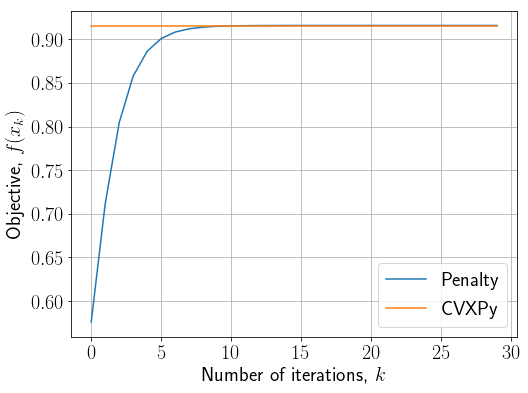

In [4]:
plt.figure(figsize=(8, 6))
fontsize=20
plt.plot(f_conv, label="Penalty")
plt.plot(np.ones(num_iters) * cvxpy_f, label="CVXPy")
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.ylabel("Objective, $f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(True)
_ = plt.yticks(fontsize=fontsize)

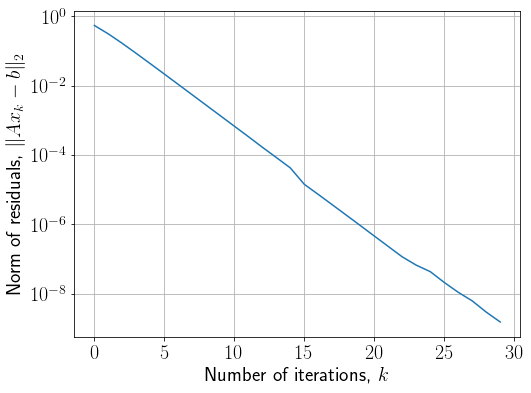

In [5]:
plt.figure(figsize=(8, 6))
fontsize=20
plt.semilogy(res_conv)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.ylabel("Norm of residuals, $\|Ax_k - b\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(True)
_ = plt.yticks(fontsize=fontsize)

## Pro & Contra

Pro

- автоматический способ превращения произвольной задачи *условной* оптимизации в задачу *безусловной* оптимизации
- начальную точку искать не надо
- часто ограничения "нестрогие" и допустимо незначительное нарушение ограничений
- простота реализации общей схемы

Contra

- решение задачи безусловной оптимизации не всегда является решением исходной задачи
- если целевая функция определена только на допустимом множестве, то метод внешних штрафов не применим
- квадратичная аппроксимация $Q(x, \mu)$ может быть неадекватной

## Двойственная задача: напоминание

- Исходная задача
 
\begin{align*}
& \min f(x) \\
\text{s.t. } & Ax = b
\end{align*}

- Лагранжиан

$$
L(x, \lambda) = f(x) + \lambda^{\top}(Ax - b)
$$

- Двойственная задача

$$
\max_{\lambda} g(\lambda), 
$$
 
где $g(\lambda) = \inf_x L(x, \lambda)$

- Восстановление решения исходной заадчи

$$
x^* = \arg\min_x L(x, \lambda^*)
$$

## Решение двойственной задачи

- Градиентный подъём, так как задача без ограничений

$$
\lambda_{k+1} = \lambda_k + \alpha_k g'(\lambda_k)
$$

- При этом градиент двойственной функции 

$$
g'(\lambda_k) = A\hat{x} - b,
$$

где $\hat{x} = \arg\min_x L(x, \lambda_k)$

- Объединим два шага в один и получим 

\begin{align*}
& x_{k+1} = \arg\min_x L(x, \lambda_k)\\
& \lambda_{k+1} = \lambda_k + \alpha_k (Ax_{k+1} - b)
\end{align*}

### Важный частный случай

- Функция сепарабельна
- Обновление $x$ распадается на параллельные задачи по каждой координате

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import cvxpy as cvx

def dual_ascent(update_x, A, b, alpha, x0, lambda0, max_iter):
    x = x0.copy()
    lam = lambda0.copy()
    conv_x = [x]
    conv_lam = [lam]
    for i in range(max_iter):
        x = update_x(x, lam, A, b)
        lam = lam + alpha * (A @ x - b)
        conv_x.append(x.copy())
        conv_lam.append(lam.copy())
    return x, lam, conv_x, conv_lam

### Модельный пример

\begin{align*}
& \min \frac{1}{2}x^{\top}Px - c^{\top}x\\
\text{s.t. } & Ax = b
\end{align*}

- Лагранжиан $L(x, \lambda) = \frac{1}{2}x^{\top}Px - c^{\top}x + \lambda^{\top}(Ax - b)$
- Обновление прямых переменных 

$$
x_{k+1} = P^{-1}(c - A^{\top}\lambda_k)
$$

In [7]:
m, n = 10, 20
A = np.random.randn(m, n)
b = np.random.randn(m)
P = np.random.randn(n, n)
P = P.T @ P
c = np.random.randn(n)
spec = np.linalg.eigvalsh(P)
mu = spec.min()
print(mu)

x = cvx.Variable(n)
obj = 0.5 * cvx.quad_form(x, P) - c @ x
problem = cvx.Problem(cvx.Minimize(obj), [A @ x == b])
problem.solve(verbose=True)
print(np.linalg.norm(A @ x.value - b))
print(problem.value)

0.0017246767769500885
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 20, constraints m = 10
          nnz(P) + nnz(A) = 410
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.6060e-01   1.94e+00   3.66e+03   1.00e-01   1.13e-03s
  50  -8.6835e-01   3.40e-09   4.93e-08   1.00e-01   1.40e-03s
plsh  -8.6835e-01   3.63e

In [9]:
x0 = np.random.randn(n)
lam0 = np.random.randn(m)

max_iter = 1000000
alpha = 1e-4

def f(x):
    return 0.5 * x @ P @ x - c @ x

def L(x, lam):
    return f(x) + lam @ (A @ x - b)

def update_x(x, lam, A, b):
    return np.linalg.solve(P, c - A.T @ lam)

x_da, lam_da, conv_x_da, conv_lam_da = dual_ascent(update_x, A, b, alpha, x0, lam0, max_iter)
print(np.linalg.norm(A @ x_da - b))
print(0.5 * x_da @ P @ x_da - c @ x_da)

2.794358332050297e-08
-0.8683463262696043


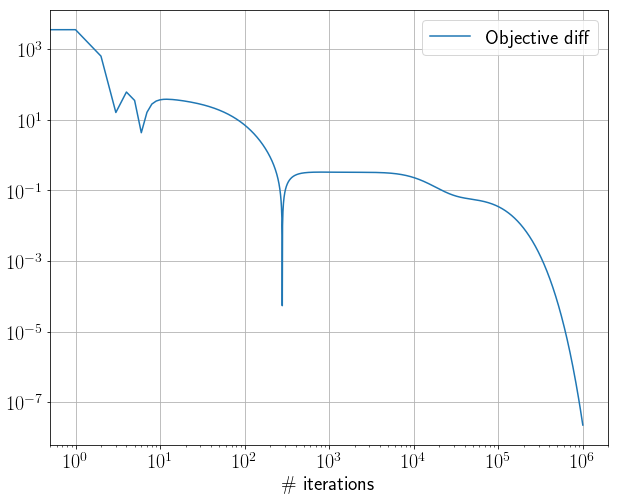

In [12]:
plt.figure(figsize=(10, 8))
# plt.plot([f(x) for x in conv_x_da], label="Objective")
# plt.plot(problem.value * np.ones(len(conv_x_da)), label="Traget value")
plt.plot([np.abs(f(x) - problem.value ) for x in conv_x_da], label="Objective diff")
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

Text(0.5, 0, '\\# iterations')

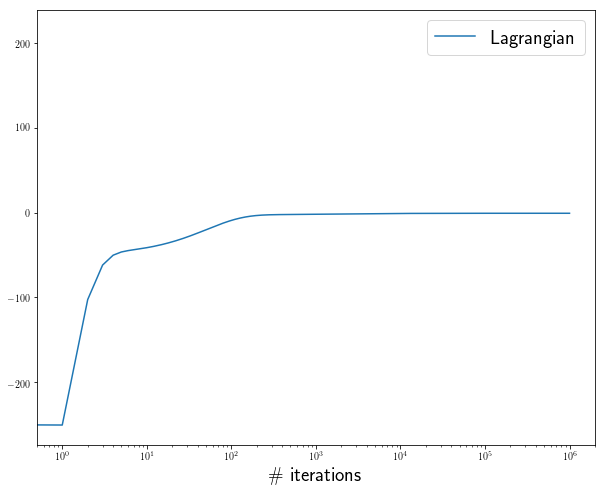

In [15]:
plt.figure(figsize=(10, 8))
plt.plot([L(x, lam) for x, lam in zip(conv_x_da, conv_lam_da)], 
         label="Lagrangian")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)

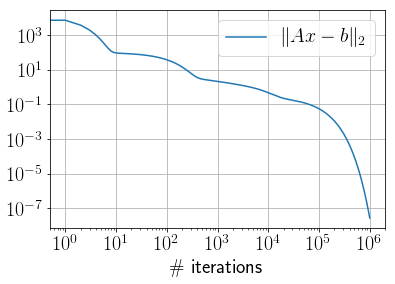

In [17]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_da], label="$\|Ax - b\|_2$")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale("log")
plt.grid(True)

## Метод модифицированной функции Лагранжа
**Мотивация:** для метода штрафных функций решения подзадач могут нарушать ограничения, и известно только, что

$$
g_i(x^*_k) \approx \frac{\lambda^*}{\mu_k} \to 0, \quad \mu_k \to \infty
$$

Можно ли изменить $Q(x, \mu)$ так, чтобы избежать этого нарушения ограничений?

**Идея:** добавлять штраф не к целевой функции, а к функции Лагранжа. Аналог прямо-двойственного метода, так как за одну итерацию происходит обновление как прямых, так и двойственных переменных

## Задача с ограничениями-равенствами

\begin{equation*}
\begin{split}
& \min f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m
\end{split}
\end{equation*}

### Модифицированная функция Лагранжа

$$
M(x, \lambda, \mu) = f(x) + \sum\limits_{i=1}^m\lambda_i g_i(x) + \frac{\mu}{2}\sum\limits_{i=1}^mg^2_i(x)
$$

Необходимое условие минимума $M(x_k, \lambda^k, \mu_k)$

$$
f'(x_k) + \sum\limits_{i=1}^m (\lambda^k_i + \mu_k g_i(x_k) ) g'_i(x_k) \approx 0
$$

Отсюда получаем выражение для $\lambda^{k+1}$

$$
\lambda^{k+1}_i = \lambda^k_i + \mu_k g_i(x_k)
$$

### Нарушение ограничений

$$
g_i(x_k) \approx \frac{\lambda^*_i - \lambda^k_i}{\mu_k} \to 0
$$
- В методе штрафных функций сходимость к 0 была порядка $1/\mu_k$
- В методе модифицированной функции Лагранжа сходимость к 0 быстрее, поскольку не только знаменатель возрастает, но и числитель стремится к 0

## Задача с ограничениями типа равенства и неравенства
\begin{equation*}
\begin{split}
& \min_x f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m \\
& h_j(x) \leq 0, \; j = 1,\ldots,p
\end{split}
\end{equation*}

### Модифицированная функция Лагранжа

$$
M(x, \mu, \lambda, \nu) = f(x) + \sum\limits_{i=1}^m \left[\lambda_ig_i(x) + \frac{\mu}{2}g^2_i(x)\right] + \frac{1}{2\mu}\sum\limits_{j=1}^p\left[ (\nu_j + \mu h_j(x))_+^2 - \nu^2_j \right],
$$
где $\lambda$ - двойственные переменные для ограничений-равенств, $\nu$ - двойственная переменная для ограничений-неравенств.

### Обновление двойственных переменных для неравенств

$$
\nu^{k+1}_j = (\nu^k_j + \mu_k h_j(x_k))_+
$$

### Общая схема 

1. Формируется функция $M$
2. По необходимым условиям находится выражение для $x_k(\lambda, \nu, \mu)$ и проверяется по достаточным условиям на минимум
3. Взятием предела по $\mu \to \infty$ при фиксированных двойственных переменных определяются прямые переменные, являющиеся решением исходной задачи
4. Выражения для $x^k$ подставляются в выражения для $\lambda$ и $\nu$
5. Взятием предела по $\mu \to \infty$ определяются двойственные переменные для найденных оптимальных прямых переменных

### Сходимость

- Локальная сходимость при выборе начального приближения достаточно близко к минимуму по прямым и двойственным переменным
- Бесконечно увеличивать параметр $\mu$ не нужно: для некоторого достаточно большого $\mu$ решения вспомогательных задач гарантировано будут сходиться к решению исходной задачи
- Решение вспомогательных задач проще, чем в методе штрафов, так как параметр $\mu$ ограничен сверху

## Практические замечания

- Метод модифицированной функции Лагранжа предпочтительнее, поскольку решение подзадачи не сложнее, чем в методе штрафов, но сходимость более быстрая
- Метод штрафов становится предпочтительным как регуляризация в подходе *последовательного квадратичного программирования* ([SQP](https://en.wikipedia.org/wiki/Sequential_quadratic_programming))
- Пакеты [LACELOT](http://www.numerical.rl.ac.uk/lancelot/blurb.html) и [MINOS](https://en.wikipedia.org/wiki/MINOS_(optimization_software)) по-разному реализуют метод модифицированной функции Лагранжа
- В [статье](https://www.dropbox.com/s/rdqcn0fppumreto/MinosvsLancelot.pdf?dl=0) приведено сравнение этих пакетов, однако они оба разработаны в начале 90х и написаны на Fortran'e

In [18]:
def augmented_lagrangian(update_x, A, b, rho0, x0, lambda0, max_iter):
    x = x0.copy()
    lam = lambda0.copy()
    conv_x = [x]
    conv_lam = [lam]
    rho = rho0
    for i in range(max_iter):
        x = update_x(x, lam, A, b)
        lam = lam + rho * (A @ x - b)
        conv_x.append(x.copy())
        conv_lam.append(lam.copy())
    return x, lam, conv_x, conv_lam

In [19]:
def update_x_al(x, lam, A, b):
    return np.linalg.solve(P + rho * A.T @ A, c - A.T @ lam + A.T @ b)

rho = 10
max_iter = 1000
x_al, lam_al, conv_x_al, conv_lam_al = augmented_lagrangian(update_x_al, A, b, rho, x0, lam0, max_iter)
print(np.linalg.norm(A @ x_al - b))
print(0.5 * x_al @ P @ x_al - c @ x_al)

8.798999020591313e-16
-0.8683463037237098


Text(0, 0.5, 'Objective')

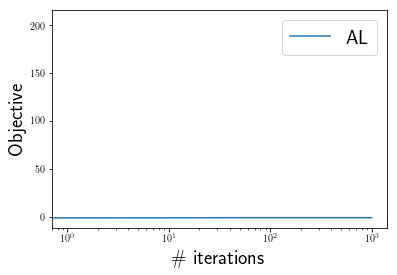

In [21]:
# plt.plot([f(x) for x in conv_x_da], label="DA")
plt.plot([f(x) for x in conv_x_al], label="AL")
# plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)

Text(0.5, 0, 'Lagrangian')

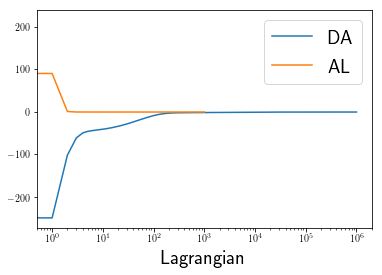

In [22]:
plt.plot([L(x, lam) for x, lam in zip(conv_x_da, conv_lam_da)], 
         label="DA")
plt.plot([L(x, lam) for x, lam in zip(conv_x_al, conv_lam_al)], 
         label="AL")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.xlabel("Lagrangian", fontsize=20)

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07, 1.e+08]), <a list of 11 Text xticklabel objects>)

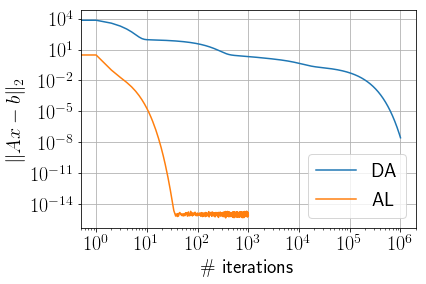

In [23]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_da], label="DA")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_al], label="AL")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\|Ax - b\|_2$", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

### Существенная проблема

- Слагаемое $\|Ax - b\|_2^2$ сделало лагранжиан НЕсепарабельным!

## Сделаем его сепарабельным и получим ADMM

Задача станет такой

\begin{align*}
& \min f(x) + I_{Ax = b} (z)\\
\text{s.t. } & x = z
\end{align*}

Для неё модифицированный лагранжиан примет вид

$$
L_{\rho}(x, z, \lambda) = f(x) + I_{Ax = b} (z) + \lambda^{\top}(x - z) + \frac{\rho}{2}\|x - z\|_2^2
$$

- Теперь метод примет вид

\begin{align*}
& x_{k+1} = \arg\min_x L_{\rho}(x, z_k, \lambda_k)\\
& z_{k+1} = \arg\min_z L_{\rho}(x_{k+1}, z, \lambda_k) \\
& \lambda_{k+1} = \lambda_k + \rho (x_{k+1} - z_{k+1})
\end{align*}
- Обновление $z$ эквивалентно $\pi_{Ax = b}(x_{k+1} + \frac{\lambda_k}{\rho})$ 

In [24]:
def admm(update_x, update_z, rho0, x0, z0, lambda0, max_iter):
    x = x0.copy()
    z = z0.copy()
    lam = lambda0.copy()
    conv_x = [x]
    conv_z = [z]
    conv_lam = [lam]
    rho = rho0
    for i in range(max_iter):
        x = update_x(x, z, lam, A, b)
        z = update_z(x, z, lam, A, b)
        lam = lam + rho * (x - z)
        conv_x.append(x.copy())
        conv_z.append(z.copy())
        conv_lam.append(lam.copy())
    return x, z, lam, conv_x, conv_z, conv_lam

In [25]:
def update_x_admm(x, z, lam, A, b):
    n = x.shape[0]
    return np.linalg.solve(P + rho*np.eye(n), -lam + c + rho * z)

def update_z_admm(x, z, lam, A, b):
    x_hat = lam / rho + x
    return x_hat - A.T @ np.linalg.solve(A @ A.T, A @ x_hat - b)

In [31]:
z0 = np.random.randn(n)
lam0 = np.random.randn(n)
rho = 1

x_admm, z_admm, lam_admm, conv_x_admm, conv_z_admm, conv_lam_admm = admm(update_x_admm, 
                                                                         update_z_admm, 
                                                                         rho, x0, z0, lam0, 
                                                                         max_iter=1000)
print(f(x_admm))

-0.868346303723712


(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 8 Text xticklabel objects>)

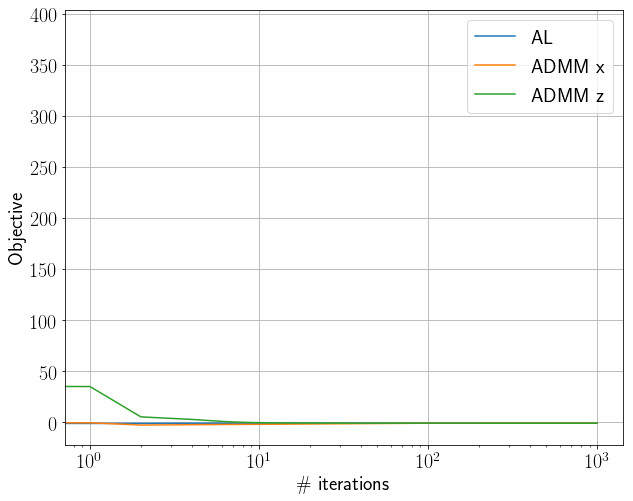

In [33]:
plt.figure(figsize=(10, 8))
# plt.plot([f(x) for x in conv_x_da], label="DA")
plt.plot([f(x) for x in conv_x_al], label="AL")
plt.plot([f(x) for x in conv_x_admm], label="ADMM x")
plt.plot([f(z) for z in conv_z_admm], label="ADMM z")
# plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

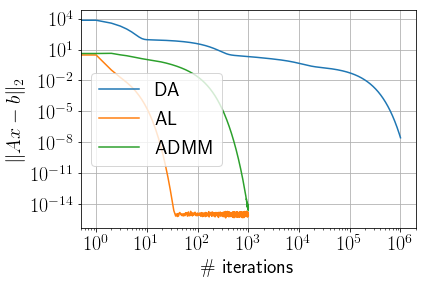

In [34]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_da], label="DA")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_al], label="AL")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_admm], label="ADMM")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\|Ax - b\|_2$", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

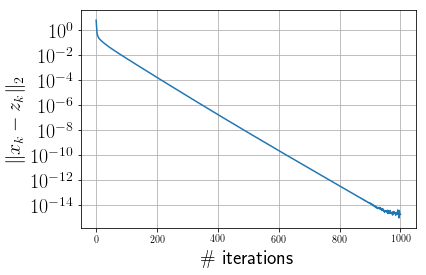

In [35]:
plt.semilogy([np.linalg.norm(x - z) for x, z in zip(conv_x_admm, conv_z_admm)])
plt.grid(True)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\|x_k - z_k\|_2$", fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Учтём, что все свойства сохранятся при аффинных преобразованиях

- Тогда наша задача в общем виде может быть записана как

\begin{align*}
& \min f(x) + g(z)\\
\text{s.t. } & Ax + Bz = d
\end{align*}

- Модифицированный лагранжиан для неё будет

$$
L_{\rho}(x, z, \lambda) = f(x) + g(z) + \lambda^{\top}(Ax + Bz - d) + \frac{\rho}{2}\|Ax + Bz - d\|_2^2
$$
- В этом случае сепарабельность по $z$ и $x$, но не внутри этих переменных
- В итоге, после внесения линейного слагаемого в квадратичное получим

\begin{align*}
& x_{k+1} = \arg\min_x \left( f(x) + \frac{\rho}{2}\|Ax + Bz_k - d + u_k \|_2^2 \right)\\
& z_{k+1} = \arg\min_z  \left( g(z) + \frac{\rho}{2}\|Ax_{k+1} + Bz - d + u_k \|_2^2 \right)\\
& u_{k+1} = u_k + x_{k+1} - z_{k+1},
\end{align*}
где $u_k = \lambda_k / \rho$

### Как это всё использовать?

- Часто приводить вашу задачу к стандартному виду с предыдущего слайда неудобно
- Поэтому лучше для конкретной задачи приводить её руками к виду, который допускает применение ADMM
- Выписать аналитически все решения вспомогательных задач
- Реализовать их вычисления наиболее оптимальным образом (сделать факторизации матриц, которые не меняются с итерациями)

## Задача линейного программирования

\begin{align*}
& \min c^{\top}x\\
\text{s.t. } & Ax = b\\
& x \geq 0
\end{align*}

- Модифицированный лагранжиан

$$
L_{\rho}(x, z, \lambda) = c^{\top}x + I_{x \geq 0}(z) + \lambda^{\top}(x - z) + \frac{\rho}{2}\|x - z\|_2^2,
$$

где $c^{\top}x$ определена на множестве $Ax = b$.

- Шаг обновления по $x$ примет вид

$$
x_{k+1} = \arg\min_{x: \; Ax = b} c^{\top}x +\lambda^{\top}x + \frac{\rho}{2}\|x - z\|_2^2
$$

- Получим систему из условий оптимальности

$$
\begin{bmatrix}
\rho I & A^{\top} \\
A & 0
\end{bmatrix}
\begin{bmatrix}
x_{k+1}\\
\mu
\end{bmatrix}
= 
\begin{bmatrix}
-\lambda_k - c + \rho z_k\\
b
\end{bmatrix}
$$

In [54]:
import scipy.optimize as scopt

m, n = 10, 200
A = np.random.rand(m, n)
b = np.random.rand(m)
c = np.random.rand(n)

scipy_linprog_conv = []
def callback_splin(cur_res):
    scipy_linprog_conv.append(cur_res)
    
res = scopt.linprog(c, A_eq=A, b_eq=b, 
                    bounds=[(0, None) for i in range(n)],
                    callback=callback_splin, method="simplex")
print(res)

     con: array([ 1.11022302e-16,  1.11022302e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  2.77555756e-17,  0.00000000e+00,  1.11022302e-16,
        3.33066907e-16,  0.00000000e+00])
     fun: 0.5021470452597288
 message: 'Optimization terminated successfully.'
     nit: 32
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0.        , 0.18015378, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.14434624, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14617574, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 

In [55]:
def update_x_admm(x, z, lam, A, b):
    n = x.shape[0]
    m = A.shape[0]
    C = np.block([[rho * np.eye(n), A.T], [A, np.zeros((m, m))]])
    rhs = np.block([-lam - c + rho * z, b])
    return np.linalg.solve(C, rhs)[:n]

def update_z_admm(x, z, lam, A, b):
    x_hat = lam / rho + x
    return np.clip(x_hat, 0, np.max(x_hat))

In [60]:
x0 = np.random.randn(n)
z0 = np.random.randn(n)
lam0 = np.random.randn(n)
rho = 10

x_admm, z_admm, lam_admm, conv_x_admm, conv_z_admm, conv_lam_admm = admm(update_x_admm, 
                                                                         update_z_admm, 
                                                                         rho, x0, z0, lam0, max_iter=10000)
print(c @ x_admm, res.fun)

0.5019354510327897 0.5021470452597288


In [61]:
print(c @ x_admm - res.fun, np.linalg.norm(x_admm - res.x))

-0.00021159422693906027 0.000715148512839466


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

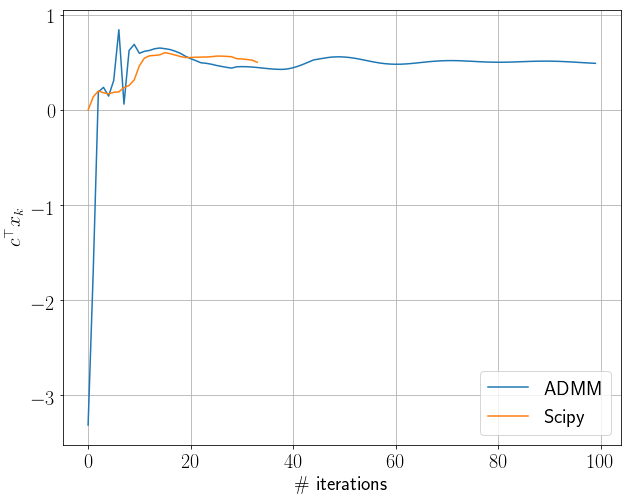

In [62]:
plt.figure(figsize=(10, 8))
plt.plot([c @ x for x in conv_x_admm[:100]], label="ADMM")
plt.plot([c @ res.x for res in scipy_linprog_conv], label="Scipy")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$c^{\\top}x_k$", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

## Комментарии

- Сходимость по итерациям медленнее, но стоимость одной итерации также меньше
- Основной выигрыш при использовании ADMM в получении не очень точного решения **параллельно** и очень быстро
- Различные способы представления задачи в виде, пригодном для использования ADMM, порождают различные методы, которые имеют различные свойства
- Например в [этой](https://papers.nips.cc/paper/6746-a-new-alternating-direction-method-for-linear-programming.pdf) статье предлагается альтернативный способ решения задачи линейного программирования через ADMM
- [Метод SCS](https://stanford.edu/~boyd/papers/pdf/scs_long.pdf), используемый по умолчанию в CVXPy, основан на применеии ADMM к коническому представлению исходной задачи 

## Выводы

- Метод внешних штрафов
- Метод двойственного подъёма
- Метод модифицированнй функции Лагранжа
- ADMM
